Rows: 30000
   age     sex    education  education-num marital-status    workclass  \
0   27    Male      HS-grad              9  Never-married      Private   
1   47    Male      Masters             14        Married    Local-gov   
2   59    Male      HS-grad              9       Divorced     Self-emp   
3   38  Female  Prof-school             15  Never-married  Federal-gov   
4   64  Female         11th              7        Widowed      Private   

        occupation  hours-per-week income  label  
0     Craft-repair              40  <=50K      0  
1  Exec-managerial              50   >50K      1  
2   Prof-specialty              20  <=50K      0  
3   Prof-specialty              57   >50K      1  
4  Farming-fishing              40  <=50K      0  
cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column
Example category mapping for each column (showing up to 8 values):
sex ['Female', 'Male'] ... -> codes [0, 1]
education ['10th', '11th', '12th', '5th-6th', '7th-8th',

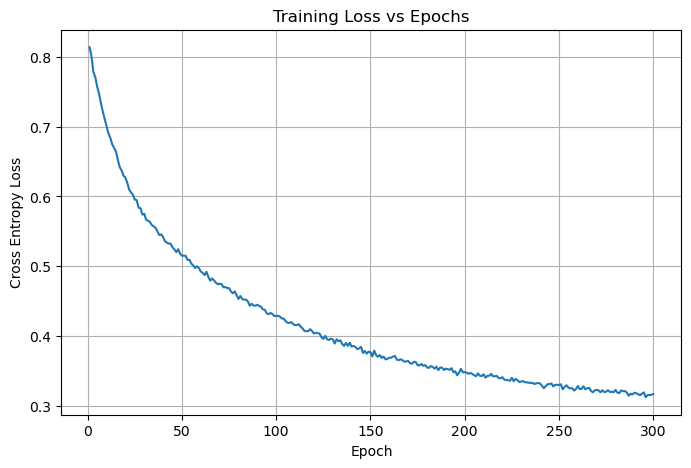

CE Loss: 0.30274084
4350 out of 5000 = 87.00% correct

Example input prediction:
Predicted label: 0 (1 means >50K, 0 means <=50K)
Probability for predicted class: 0.9411
All class probabilities: [0.9411143  0.05888577]


In [3]:
# Neural Network Exercises - Full solution
# Requirements: torch, pandas, numpy, matplotlib, scikit-learn
# Run in a Jupyter notebook or a .py file (if .py, remove %matplotlib inline)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time

# If using Jupyter:
# %matplotlib inline

# ---------------------------
# 0) Load dataset
# ---------------------------
# Change the path if needed
df = pd.read_csv('income.csv')
print("Rows:", len(df))
print(df.head())

# ---------------------------
# 1) Separate categorical, continuous, label
# ---------------------------
# According to the exercise description:
# categorical: sex, education (or education-num), marital-status, workclass, occupation
# continuous: age, hours-per-week
# label column: 'label' (0/1)

cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

# ---------------------------
# 2) Convert categorical columns to pandas "category" dtype
# ---------------------------
for c in cat_cols:
    df[c] = df[c].astype('category')

# Save category mappings so we can map user-input later (and to ensure reproducibility)
cat_maps = {}
for c in cat_cols:
    # pandas category stores categories in alphabetical order by default (preserves order at creation).
    # We'll keep the category order as-is (based on the dataset). Save mapping value -> code.
    cat_maps[c] = {cat: code for code, cat in enumerate(df[c].cat.categories)}

# Example mapping print (optional)
print("Example category mapping for each column (showing up to 8 values):")
for c in cat_cols:
    keys = list(cat_maps[c].keys())[:8]
    print(c, keys, "... -> codes", [cat_maps[c][k] for k in keys])

# ---------------------------
# Optional: Shuffle dataset (comment/uncomment if needed)
# ---------------------------
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)

# ---------------------------
# 3) Embedding sizes
# ---------------------------
# cat_szs: number of unique categories in each categorical column
cat_szs = [len(df[c].cat.categories) for c in cat_cols]

# A common heuristic for embedding size is min(50, (cat_size+1)//2) or sqrt(cat_size)
# We'll use a small heuristic: embedding size = min(50, (size+1)//2)
emb_szs = [(sz, min(50, (sz+1)//2)) for sz in cat_szs]
print("cat_szs:", cat_szs)
print("emb_szs:", emb_szs)

# If you want the exact example tuple from exercise: they had [(2,1),(14,7),(6,3),(5,3),(12,6)]
# The heuristic above will produce similar sizes.

# ---------------------------
# 4) Create array of categorical values (cats)
# ---------------------------
# Use .cat.codes to get integer codes. Stack them column-wise.
cats_np = np.stack([df[c].cat.codes.values for c in cat_cols], axis=1).astype('int64')
print("cats_np shape:", cats_np.shape)
print("cats_np[:5]:\n", cats_np[:5])

# ---------------------------
# 5) Convert cats to tensor (int64)
# ---------------------------
cats = torch.tensor(cats_np, dtype=torch.int64)

# ---------------------------
# 6) Create conts array (continuous variables)
# ---------------------------
conts_np = np.stack([df[c].values for c in cont_cols], axis=1).astype('float32')
print("conts_np[:5]:\n", conts_np[:5])

# ---------------------------
# 7) Convert conts to tensor (float32)
# ---------------------------
conts = torch.tensor(conts_np, dtype=torch.float32)

# ---------------------------
# 8) Create label tensor y (flattened)
# ---------------------------
y_np = df[y_col[0]].values.astype('int64')
y = torch.tensor(y_np, dtype=torch.long).view(-1)  # shape (N,)

# ---------------------------
# 9) Train/test split
# ---------------------------
# We'll create a train/test split keeping test set separate.
# The exercise suggests batch (b)=30000 and test (t)=5000,
# but we'll use sklearn train_test_split to be explicit and reproducible.

test_size = 5000
N = len(df)
train_size = N - test_size

# Create indices and slice tensors
b = N
t = test_size

cat_train = cats[:train_size]
cat_test  = cats[train_size:train_size+test_size]

con_train = conts[:train_size]
con_test  = conts[train_size:train_size+test_size]

y_train = y[:train_size]
y_test  = y[train_size:train_size+test_size]

print("train/test sizes:", len(y_train), len(y_test))

# ---------------------------
# 10) Set random seed for reproducibility
# ---------------------------
torch.manual_seed(33)
np.random.seed(33)

# ---------------------------
# 11) Define the TabularModel class (given in exercise)
# ---------------------------
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

# ---------------------------
# 11b) Create model instance
# One hidden layer with 50 neurons and p=0.4 dropout
# Output size = 2 (binary classification, we'll use CrossEntropyLoss)
# ---------------------------
model = TabularModel(emb_szs=emb_szs, n_cont=len(cont_cols), out_sz=2, layers=[50], p=0.4)
print(model)

# ---------------------------
# 12) Loss and optimizer
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 13) Train the model
# ---------------------------
# We'll run for 300 epochs (as in the exercise). It might take a while depending on machine.
epochs = 300
losses = []
start_time = time.time()

# Move model to device if GPU available (optional)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
cat_train = cat_train.to(device)
con_train = con_train.to(device)
y_train = y_train.to(device)

for i in range(1, epochs+1):
    model.train()
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    if i % 25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {epochs:3}  loss: {loss.item():10.8f}')
print(f'Duration: {time.time() - start_time:.0f} seconds')

# ---------------------------
# 14) Plot Cross Entropy Loss vs epochs
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()

# ---------------------------
# 15) Evaluate on test set
# ---------------------------
model.eval()
cat_test = cat_test.to(device)
con_test = con_test.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    y_val_logits = model(cat_test, con_test)  # raw logits
    loss_test = criterion(y_val_logits, y_test)
    # Convert logits to predicted class
    preds = torch.argmax(y_val_logits, dim=1)
    
# Print CE Loss on test set
print(f'CE Loss: {loss_test.item():.8f}')

# ---------------------------
# 16) Percent accuracy on test set
# ---------------------------
correct = (preds == y_test).sum().item()
total = y_test.size(0)
acc = correct / total * 100.0
print(f'{correct} out of {total} = {acc:.2f}% correct')

# ---------------------------
# BONUS: Function to predict on a single new user input
# ---------------------------
# We will use the saved cat_maps (which map category string -> code based on training df).
# The function below will be robust to capitalization and will try to match input strings.
# If an unknown category is provided, it prints a warning and uses a fallback (0).

def _map_category(col_name, value):
    """Map a user string to the integer code for column col_name using cat_maps.
       Case-insensitive match is attempted. If not found, fallback to 0 and warn."""
    if value is None:
        return 0
    # try exact match first
    if value in cat_maps[col_name]:
        return cat_maps[col_name][value]
    # try case-insensitive match
    for k in cat_maps[col_name].keys():
        if str(k).lower() == str(value).strip().lower():
            return cat_maps[col_name][k]
    # try startswith or contains (loose match)
    vlow = str(value).strip().lower()
    for k in cat_maps[col_name].keys():
        klow = str(k).lower()
        if klow.startswith(vlow) or vlow in klow:
            return cat_maps[col_name][k]
    # unknown: fallback 0 but warn
    print(f"Warning: '{value}' not found for column '{col_name}' — using fallback code 0.")
    return 0

def predict_single(model, age, sex, education, marital_status, workclass, occupation, hours_per_week):
    """
    Accepts user inputs, maps to numeric codes using training mapping, constructs tensors,
    and returns predicted label (0 or 1) plus probability for predicted class.
    """
    # Map categorical fields
    sex_code = _map_category('sex', sex)
    edu_code = _map_category('education', education)
    mar_code = _map_category('marital-status', marital_status)
    wc_code  = _map_category('workclass', workclass)
    occ_code = _map_category('occupation', occupation)
    
    cat_list = [sex_code, edu_code, mar_code, wc_code, occ_code]
    cat_tensor = torch.tensor([cat_list], dtype=torch.int64).to(device)
    
    # Continuous features: age and hours-per-week (as float)
    cont_list = [float(age), float(hours_per_week)]
    cont_tensor = torch.tensor([cont_list], dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(cat_tensor, cont_tensor)  # shape (1,2)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = int(np.argmax(probs))
        pred_prob = float(probs[pred_class])
    return pred_class, pred_prob, probs

# ---------------------------
# Example interactive usage (comment/uncomment when running)
# ---------------------------
# The following interactive block is for console/Jupyter. If using .py, keep as is.
def interactive_predict():
    print("Please enter the person's details (press Enter after each):")
    age = input("What is the person's age? (18-90) ")
    sex = input("What is the person's sex? (Male/Female) ")
    education = input("What is the person's education? (e.g., HS-grad, Bachelors, Masters, etc.) ")
    marital = input("What is the person's marital status? (e.g., Married, Never-married, Divorced, Widowed, Separated, Married-spouse-absent) ")
    workclass = input("What is the person's workclass? (e.g., Private, Local-gov, State-gov, Self-emp, Federal-gov) ")
    occupation = input("What is the person's occupation? (e.g., Sales, Exec-managerial, Prof-specialty, Craft-repair, etc.) ")
    hours = input("How many hours/week are worked? (20-90) ")
    
    pred_class, pred_prob, probs = predict_single(model, age, sex, education, marital, workclass, occupation, hours)
    print("\nPrediction result:")
    print("Predicted label:", pred_class, "(1 means >50K, 0 means <=50K)")
    print(f"Predicted probability for class {pred_class}: {pred_prob:.4f}")
    print(f"Full class probabilities: {probs}")
    return pred_class

# If you want to run interactive prompt now, uncomment below:
# interactive_predict()

# ---------------------------
# Quick non-interactive example (matching the example from prompt)
# ---------------------------
# Example values (as in the user's final example)
example_input = {
    'age': 22,
    'sex': 'male',
    'education': '12',           # note: in their prompt they used numeric education; but training uses text like 'HS-grad' etc.
    'marital_status': 'married',
    'workclass': 'private',
    'occupation': 'sales',
    'hours_per_week': 40
}

# Because dataset uses text categories for 'education' (like 'HS-grad', 'Bachelors'), user may provide numeric education-num.
# If user gives a numeric education level, we should map to nearest textual education if possible, but here we'll try to use it directly.
# Let's try a safe call while being tolerant to inputs:

# If user gives education as numeric (e.g., '12' or 12), try to map to a textual category in df that contains '12' or equals '12'
edu_input = str(example_input['education'])
pred_class, pred_prob, probs = predict_single(
    model,
    age=example_input['age'],
    sex=example_input['sex'],
    education=edu_input,
    marital_status=example_input['marital_status'],
    workclass=example_input['workclass'],
    occupation=example_input['occupation'],
    hours_per_week=example_input['hours_per_week']
)

print("\nExample input prediction:")
print("Predicted label:", pred_class, "(1 means >50K, 0 means <=50K)")
print(f"Probability for predicted class: {pred_prob:.4f}")
print(f"All class probabilities: {probs}")
